In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import numpy.matlib
import pickle

In [2]:
sheet = pd.read_excel('../data/eye_diagnose.xls', sheet_name=0, header=1)
sheet = sheet.drop_duplicates()
sheet = sheet.reset_index().drop(columns=['index'])
sheet.head()

,病案号码,病人性质名称,病人性别,病人年龄,入院途径,入院情况,入院日期,出院日期,门诊诊断,入院诊断,...,球蛋白类制品费,细胞因子类制品费,血蛋白类制品费,中医治疗费,其他费1,其他费2,损伤中毒,并发症,第一感染,其它诊断名称
0,1000427842,城镇职工基本医疗保险,男,29岁,其他医疗机构转入,一般,2012-12-27,2013-01-02,环状视网膜病,视网膜脱离,...,0,0,0,0,102.0,1400.0,NaN,NaN,NaN,屈光不正
1,1000428273,城镇职工基本医疗保险,女,63岁,其他医疗机构转入,一般,2012-12-31,2013-01-02,晶体混浊,白内障,...,0,0,0,0,0.0,0.0,NaN,NaN,NaN,糖尿病不伴有并发症
2,1000428273,城镇职工基本医疗保险,女,63岁,其他医疗机构转入,一般,2012-12-31,2013-01-02,晶体混浊,白内障,...,0,0,0,0,0.0,0.0,NaN,NaN,NaN,特发性(原发性)高血压
3,1000428485,全自费,男,46岁,其他医疗机构转入,一般,2013-01-01,2013-01-03,泪小管断裂,泪小管裂伤,...,0,0,0,0,27.4,0.0,被别人殴打、踢、拧、咬或抓伤,NaN,NaN,NaN
4,1000428555,城镇职工基本医疗保险,男,29岁,急诊,一般,2013-01-02,2013-01-03,NaN,眼睑囊肿,...,0,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN


In [3]:
tmp = sheet[["病案号码", "病人性质名称", "病人性别", "病人年龄", "入院途径", "门诊诊断", "入院诊断", "主要诊断", "手术名称"]]

In [4]:
tmp.head()

,病案号码,病人性质名称,病人性别,病人年龄,入院途径,门诊诊断,入院诊断,主要诊断,手术名称
0,1000427842,城镇职工基本医疗保险,男,29岁,其他医疗机构转入,环状视网膜病,视网膜脱离,视网膜脱离,后入路玻璃体切割术
1,1000428273,城镇职工基本医疗保险,女,63岁,其他医疗机构转入,晶体混浊,白内障,白内障,NaN
2,1000428273,城镇职工基本医疗保险,女,63岁,其他医疗机构转入,晶体混浊,白内障,白内障,NaN
3,1000428485,全自费,男,46岁,其他医疗机构转入,泪小管断裂,泪小管裂伤,泪小管裂伤,泪小管吻合术
4,1000428555,城镇职工基本医疗保险,男,29岁,急诊,NaN,眼睑囊肿,眼睑囊肿,眼睑囊肿摘除术


In [5]:
tmp = tmp.rename(columns={"病案号码":"number", "病人性质名称":"type", "病人性别":"sex", "病人年龄":"age", "入院途径":"to_hospital", "门诊诊断":"diag_1", "入院诊断":"diag_2", "主要诊断":"diag_3", "手术名称":"operation_name"})

In [6]:
type(tmp['age'][0]) == str

True

In [7]:
for i in range(len(tmp['age'])):
    if type(tmp['age'][i]) == str:
        if len(tmp['age'][i].split('个')) == 2:
            tmp['age'][i] = 0 
        else:
            tmp['age'][i] = int(tmp['age'][i].split('岁')[0])
        # 存在‘2个月5天’，以及‘7岁7月’的现象
        # print(tmp['age'][i])

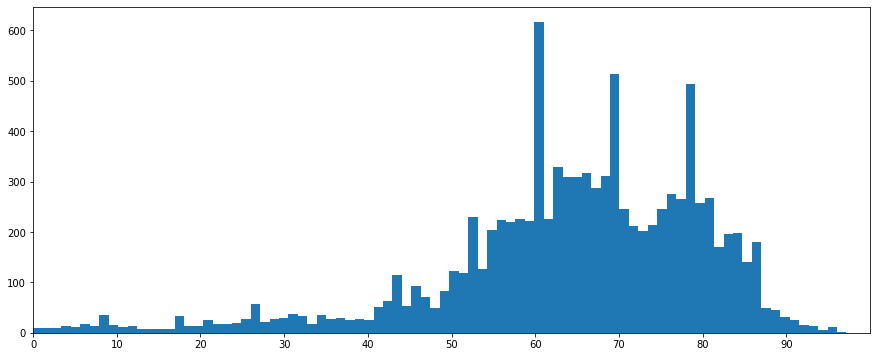

In [8]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)
ax.hist(tmp['age'], bins=100)
ax.set_xlim(0, 100)
ax.set_xticks(range(0,100,10))
plt.show()

In [9]:
age_list = [[0, 20], [20, 30], [30, 40], [40, 45], [45, 50], [50, 55], [55, 57], [57, 60], [60, 63], [63, 65], [65, 67], [67, 70], [70, 73], [73, 75], [75, 77], [77, 80], [80, 83], [83, 85], [85, 90], [90, 150]]
for i in range(len(age_list)):
    print(tmp['age'][(tmp['age'] >= age_list[i][0]) & (tmp['age'] < age_list[i][1])].count())

240
228
262
253
349
597
427
667
841
637
624
832
737
415
521
758
695
393
417
105


In [10]:
node_list = []
for i in range(len(tmp)):
    for c_idx in tmp.columns:
        if (c_idx != 'age') and (c_idx != 'sex') and (tmp[c_idx][i] not in node_list):
            node_list.append(tmp[c_idx][i])

In [11]:
node_list.extend(['男', '女'])
for i in age_list:
    node_list.append('age:%d-%d' %(i[0], i[1]))
node_size = len(node_list)
print(node_size)

7752


In [12]:
node_df = pd.DataFrame(node_list)

In [16]:
node_df[node_df.values == 1000427842].index

Int64Index([0], dtype='int64')

In [21]:
node_matrix = np.matlib.zeros((node_size, node_size))
for i in range(node_size):
    if (i+1) % 500 == 0:
        print('%d done!' %(i + 1))
    j = node_df[node_df.values == tmp['number'][i]].index
    for c_idx in tmp.columns[1:]:
        if c_idx != 'age':
            k = node_df[node_df.values == tmp[c_idx][i]].index
            # print(k)
            node_matrix[i, k] = 1
            node_matrix[k, i] = 1
        else:
            for p in age_list:
                if tmp[c_idx][i] < p[1] and tmp[c_idx][i] >= p[0]:
                    k = node_df[node_df.values == 'age:%d-%d' %(p[0], p[1])].index
                    node_matrix[i, k] = 1
                    node_matrix[k, i] = 1
with open('../data/node_matrix.pickle', 'wb') as f:
    pickle.dump(node_matrix, f)

500 done!
1000 done!
1500 done!
2000 done!
2500 done!
3000 done!
3500 done!
4000 done!
4500 done!
5000 done!
5500 done!
6000 done!
6500 done!
7000 done!
7500 done!


In [22]:
with open('../data/node_df.pickle', 'wb') as f:
    pickle.dump(node_df, f)

In [25]:
node_df.to_csv('../data/node.csv', encoding='GBK')